<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/main/Project_ray_6_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 22.1MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.5MB/s]


In [ ]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [150, 150]

train_path = '/content/chest_xray/chest_xray/train'
valid_path = '/content/chest_xray/chest_xray/test'

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/chest_xray/chest_xray/train/*')
folders

['/content/chest_xray/chest_xray/train/PNEUMONIA',
 '/content/chest_xray/chest_xray/train/NORMAL']

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
from keras.layers import Dropout
x = GlobalAveragePooling2D()(resnet.output)
x = Flatten(name='flatten')(x)
x = Dense(64, activation='relu', name='fc1')(x)
x = Dropout(0.2, name='drop1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
x = Dropout(0.2, name='drop2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

In [ ]:
model = Model(inputs=resnet.input, outputs=x)

In [ ]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr= 0.00001)
model.compile(
  loss='categorical_crossentropy',
  optimizer= opt,
  metrics=['accuracy']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 9,
                                  zoom_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
val_set = val_datagen.flow_from_directory('/content/chest_xray/chest_xray/val',
                                            target_size = (150, 150),
                                            class_mode = 'categorical')

Found 16 images belonging to 2 classes.


In [ ]:
len(val_set)

1

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/8
163/163 [==============================] - 81s 495ms/step - loss: 0.5824 - accuracy: 0.7370 - val_loss: 0.6815 - val_accuracy: 0.6250
Epoch 2/8
163/163 [==============================] - 80s 490ms/step - loss: 0.5653 - accuracy: 0.7431 - val_loss: 0.6599 - val_accuracy: 0.6250
Epoch 3/8
163/163 [==============================] - 81s 498ms/step - loss: 0.5513 - accuracy: 0.7427 - val_loss: 0.6529 - val_accuracy: 0.6250
Epoch 4/8
163/163 [==============================] - 82s 504ms/step - loss: 0.5330 - accuracy: 0.7419 - val_loss: 0.6440 - val_accuracy: 0.6250
Epoch 5/8
163/163 [==============================] - 82s 501ms/step - loss: 0.5222 - accuracy: 0.7425 - val_loss: 0.6020 - val_accuracy: 0.6250
Epoch 6/8
163/163 [==============================] - 81s 498ms/step - loss: 0.5069 - accuracy: 0.7450 - val_loss: 0.5761 - val_accuracy: 0.6362
Epoch 7/8
163/163 [==============================] - 81s 498ms/step - loss: 0.4904 - accuracy: 0.7554 - val_loss: 0.5760 - val_accuracy:

In [ ]:
model.evaluate(test_set)

20/20 [==============================] - 5s 268ms/step - loss: 0.4714 - accuracy: 0.7788


[0.47140100598335266, 0.7788461446762085]

In [ ]:
model.evaluate(val_set)

1/1 [==============================] - 0s 1ms/step - loss: 0.9186 - accuracy: 0.6250


[0.9186335802078247, 0.625]

In [ ]:
prediction= model.predict_generator(val_set)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
prediction

array([[6.0137588e-01, 3.9862415e-01],
       [6.0137588e-01, 3.9862415e-01],
       [9.5690470e-03, 9.9043089e-01],
       [3.6792429e-03, 9.9632072e-01],
       [5.0150800e-02, 9.4984913e-01],
       [1.9271929e-02, 9.8072815e-01],
       [3.8377877e-02, 9.6162218e-01],
       [3.2432113e-02, 9.6756786e-01],
       [4.2389506e-01, 5.7610488e-01],
       [4.3429915e-04, 9.9956566e-01],
       [1.9629946e-02, 9.8037004e-01],
       [6.6332571e-02, 9.3366742e-01],
       [3.0509947e-02, 9.6949011e-01],
       [2.3835259e-03, 9.9761653e-01],
       [1.2747121e-01, 8.7252879e-01],
       [1.4277066e-01, 8.5722935e-01]], dtype=float32)

In [ ]:
pred1 = np.argmax(prediction,axis = 1) 


In [ ]:
pred1

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cm = confusion_matrix(y_true, pred1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

NameError: ignored

In [ ]:
print('True Positive  (TP) = ', cm[0][0])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[1][1])
print('-'*26)

True Positive  (TP) =  2
False Positive (FP) =  6
False Negative (FN) =  4
True Negative  (TN) =  4
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

Precision Score: 25.0%
Recall Score: 33.33%
F1 Score: 28.57%




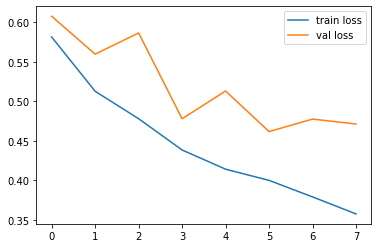

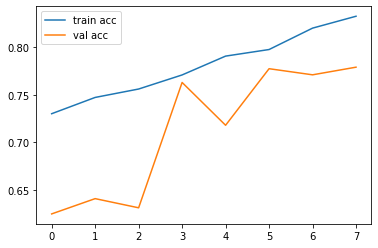

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [ ]:
TRAIN_DIR = "/content/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/chest_xray/val/"

In [ ]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [ ]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [ ]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(y_test, 2)


In [ ]:
print(y_test.shape)

(16, 2)


In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

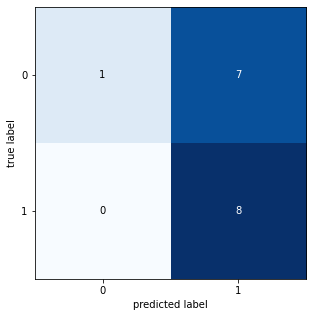

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
print('True Positive  (TP) = ', cm[0][0])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[1][1])
print('-'*26)

True Positive  (TP) =  2
False Positive (FP) =  6
False Negative (FN) =  0
True Negative  (TN) =  8
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

Precision Score: 25.0%
Recall Score: 100.0%
F1 Score: 40.0%


